# Курсовая работа


                Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.887600     54.598396     36.408562   
std     4859.01902     43.587592      0.811438     15.630079     10.212496   
min        0.00000      0.000000      1.000000     32.105183     29.105183   
25%     4169.50000     20.000000      1.000000     41.774881     29.105183   
50%     8394.50000     36.000000      2.000000     52.513040     32.781260   
75%    12592.50000     75.000000      2.000000     64.591720     39.966602   
max    16798.00000    209.000000      5.000000    100.904263     80.664209   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean        6.238200      7.433800     12.931500   1984.872400      0.118858   
std         2.794717      5.041662      6.241322     18.4

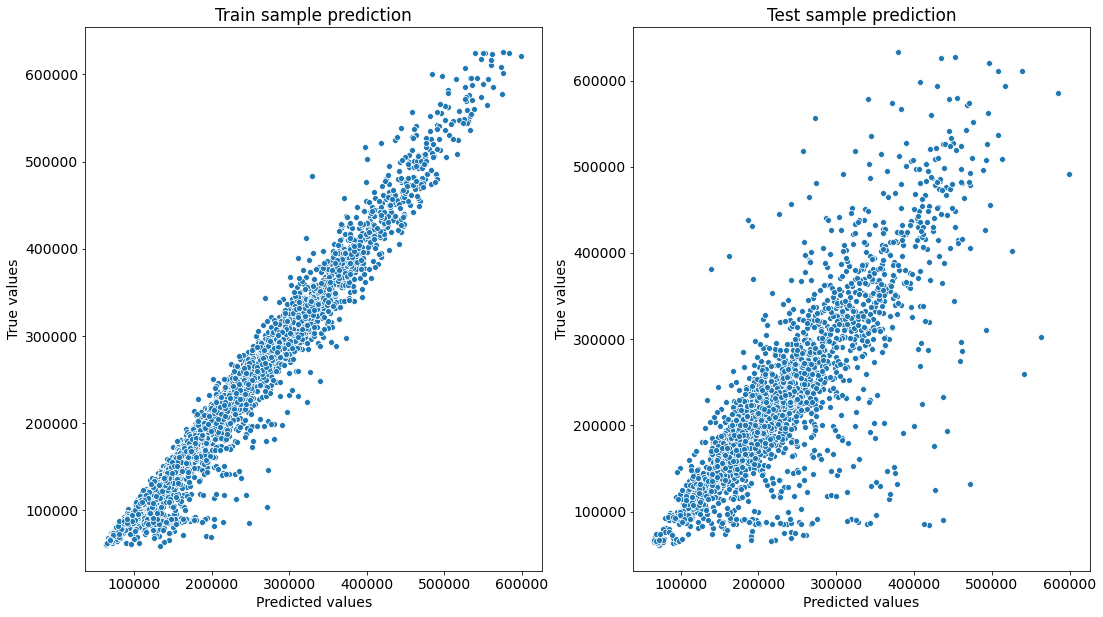

[153575.00851278 212188.05624809 274875.75104481 ... 323145.59149653
 191618.26411448 155817.89750224]


In [120]:

# подключим необходимые библиотеки


import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

#import xgboost as xgb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

class FlatPreprocessor:
    """Подготовка данных"""       
    
    def transform(self, train_df, test_df):
        """Сохранение статистик"""  
        
        # Расчет медиан
        self.medians = train_df.median()
        
        # get quantiles
        self.square_quantile_95 = train_df['Square'].quantile(.975)
        self.square_quantile_25 = train_df['Square'].quantile(.025)
        
        self.kitchen_square_quantile_95 = train_df['KitchenSquare'].quantile(.975)
        self.life_square_quantile_95 = train_df['LifeSquare'].quantile(.975)
        
        self.house_floor_quantile_95 = train_df['HouseFloor'].quantile(.975)
        
        # transform
        self.train_df = self.process_data(train_df)
        self.test_df = self.process_data(test_df)
    
    def process_data(self, X):
        """Трансформация данных"""

        # комнаты
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # площадь
        X['Square_outlier'] = 0
        out_condition = (X['Square'].isna()) | (X['Square'] > self.square_quantile_95) | (X['Square'] < self.square_quantile_25)
        X.loc[out_condition, 'Square_outlier'] = 1
        
        condition = (X['Square'].isna()) | (X['Square'] > self.square_quantile_95)
        X.loc[condition, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < self.square_quantile_25, 'Square'] = self.square_quantile_25
        
        # кухонная площадь
        X['KitchenSquare_outlier'] = 0
        out_condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile_95) | (X['KitchenSquare'] < 3)
        X.loc[out_condition, 'KitchenSquare_outlier'] = 1
        
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile_95)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # жилая площадь
        X['LifeSquare_outlier'] = 0
        out_condition = (X['LifeSquare'].isna()) | (X['LifeSquare'] > self.kitchen_square_quantile_95) | (X['LifeSquare'] < self.square_quantile_25)
        X.loc[out_condition, 'LifeSquare_outlier'] = 1
        
        condition = (X['LifeSquare'].isna()) | (X['LifeSquare'] > self.life_square_quantile_95)
        X.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']
        
        # берем квантиль от всей площади и вычитаем 3 
        X.loc[X['LifeSquare'] < self.square_quantile_25, 'LifeSquare'] = self.square_quantile_25 - 3
        
        # пропуски по жилой площади
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # этажи
        condition = (X['HouseFloor'] == 0) | (X['HouseFloor'] > 95)
        X.loc[condition, 'HouseFloor_outlier'] = 1
        X.loc[condition, 'HouseFloor'] = self.medians['HouseFloor']
        
        X['HouseFloor_outlier'] = 0
        X.loc[(X['Floor'] > X['HouseFloor']) | (X['HouseFloor'] == 0) | (X['HouseFloor'] > 95), 'HouseFloor_outlier'] = 1
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # год
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X
        

class FlatFeatureGenetator():
    """Генерация новых фич"""
    
    def sqaure_to_cat_pandas(self, X):
        bins = [X['Square'].min(), 45, 60, 75, X['Square'].max()]
        X['Square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
        X['Square_cat'].fillna(60, inplace=True)
        return X
    
    def transform(self, train_df, test_df):
        
        X = train_df.copy()
        
        # district size
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        
        self.train_df = self.process_data(train_df)
        self.test_df = self.process_data(test_df)

    def process_data(self, X):
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X = self.sqaure_to_cat_pandas(X)

        return X  

class ML:
    """Класс для машинного обучения"""
    
    def __init__(self, train_path, test_path, preprocessor, feature_genetator):
        """Конструктор"""
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.preprocessor = preprocessor
        self.feature_genetator = feature_genetator
      
    def evaluate_preds(self, train_true_values, train_pred_values, test_true_values, test_pred_values):
        """Эффективнсть модели"""
        
        print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
        print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

        plt.figure(figsize=(18,10))

        plt.subplot(121)
        sns.scatterplot(x=train_pred_values, y=train_true_values)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('Train sample prediction')

        plt.subplot(122)
        sns.scatterplot(x=test_pred_values, y=test_true_values)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('Test sample prediction')

        plt.show()
    
    def predict(self):
        """Обучаем модель"""
        
        feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

        new_feature_names = ['Rooms_outlier', 'Square_outlier', 'KitchenSquare_outlier', 'LifeSquare_outlier', 'HouseFloor_outlier',
                             'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                             'Square_cat']

        target_name = 'Price'
        
        X = self.train_df[feature_names + new_feature_names]
        y = self.train_df[target_name]

        self.test_df = self.test_df[feature_names + new_feature_names]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)
        
        rf_model = RandomForestRegressor(random_state=21, criterion='mse')

        rf_model.fit(X_train, y_train)
        
        y_train_preds = rf_model.predict(X_train)
        y_test_preds = rf_model.predict(X_test)
        
        print('')
        print('Кросс-валидация')
        cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
        print(cv_score.mean())
        
        print('')
        print('Главные фичи')
        feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

        print(feature_importances.sort_values(by='importance', ascending=False))
        
        print('')
        print('Эффективность модели')
        self.evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)
        
        # итоговые предсказания
        submit = pd.read_csv('./data/sample_submission.csv')
        predictions = rf_model.predict(self.test_df)
        print(predictions)
        submit['Price'] = predictions
        submit.to_csv('rf_submit.csv', index=False)
        
        
    
    def learn(self):
        """Главный метод для обучения"""
        
        
        
        # 0. EDA
        self.preprocessor.transform(self.train_df, self.test_df)
        self.train_df = self.preprocessor.train_df
        self.test_df = self.preprocessor.test_df

        print(self.train_df.describe())
        
        # 1. Добавлям фичи
        self.feature_genetator.transform(self.train_df, self.test_df)
        self.train_df = self.feature_genetator.train_df
        self.test_df = self.feature_genetator.test_df

        # 2. Обучаем модель и предсказываем значения
        self.predict()
    


# ЗАПУСК ПРИЛОЖЕНИЯ
ml = ML('./data/train.csv', './data/test.csv', FlatPreprocessor(), FlatFeatureGenetator())
ml.learn()